# COMP90051 Workshop 3
## Linear regression

***

In this worksheet, we'll explore ordinary least squares (OLS) regression: both simple linear regression and basis function regression. Our key objectives are:

* to implement OLS regression using numerical linear algebra functions from the `numpy` library
* to practice using the scikit-learn interface for linear regression
* to implement basis function regression as an extension of OLS linear regression

Firstly, we'll import the relevant libraries (`numpy`, `matplotlib`, etc.).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 108

### 1. The Boston Housing dataset

Throughout this worksheet, we'll use the _Boston Housing dataset_ as an example. 
It contains data about towns in the Boston area, which can be used to predict median house values. 
There are 506 observations in total, each of which is described by 13 features, such as _per capita crime rate_, _percentage of population with a lower socio-economic status_, etc. 
You can read more about the features [here](http://lib.stat.cmu.edu/datasets/boston).

Let's begin by loading the data and converting to a Pandas dataframe.

In [2]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
columns = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]
ds = pd.DataFrame(np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]]), columns=columns)
y = pd.Series(raw_df.values[1::2, 2], name="MEDV")
ds.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


To keep things simple, we'll work with a single feature called `LSTAT` for now. 
It corresponds to the percentage of the population in the town classified as 'lower status' by the US Census service in 1978. 
Note that the response variable (the median house value in the town) is denoted `MEDV`.
Plotting the  `MEDV` vs. `LSTAT` we see that a linear model appears plausible:

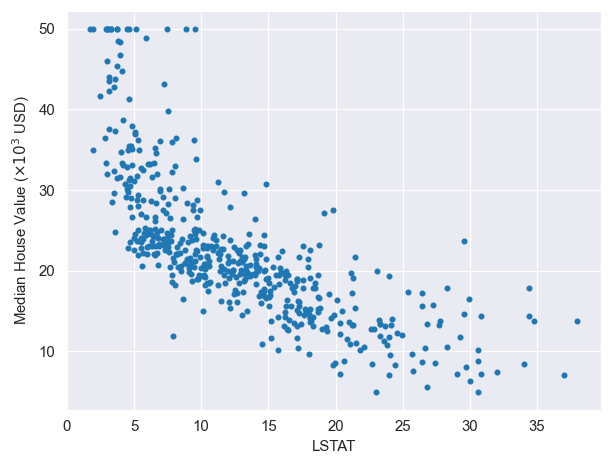

In [3]:
features = ['LSTAT']

for f in features:
    plt.figure()
    plt.scatter(ds[f], y, marker='.')
    plt.xlabel(f)
    plt.ylabel(r'Median House Value ($\times 10^3$ USD)')

***
**Question:** Have we made any mistakes in our analysis so far?
***

Let's now randomly split the data into training and test sets.
This is necessary, so we can assess the generalisation error of our model later on.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ds, y, test_size=0.2, random_state=90051)
print("Training set has {} instances. Test set has {} instances.".format(X_train.shape[0], X_test.shape[0]))
# select subset of the features
X_train_s = X_train[features].values
X_test_s = X_test[features].values

Training set has 404 instances. Test set has 102 instances.


### 2. Linear algebra solution

Let's now fit a linear regression model to the single-featured Boston Housing data. 
In order to appreciate the lower-level details, we'll start by fitting the model using numerical linear algebra functions. 
The same approach is used under the hood in machine learning libraries, such as scikit-learn.

***
**Exercise:** In lectures, we derived an analytic expression for the optimal weights $\mathbf{w}^* = \left[\mathbf{X}^\top \mathbf{X}\right]^{-1} \mathbf{X}^\top \mathbf{y}$. Attempt the derivation yourself using the following matrix calculus identities: 

$$
\begin{gather}
    \nabla_{\mathbf{w}} \mathbf{w}^\top \mathbf{x} = \nabla_{\mathbf{w}} \mathbf{x}^\top \mathbf{w} = \mathbf{x}^\top \\
    \nabla_{\mathbf{w}} \mathbf{A}\mathbf{w} = \mathbf{A} \\
    \nabla_{\mathbf{w}} \mathbf{w}^\top \mathbf{A}\mathbf{w} = \mathbf{w}^\top \left(\mathbf{A}^\top + \mathbf{A}\right)
\end{gather}
$$

where vector $\mathbf{x}$ and matrix $\mathbf{A}$ are constants (independent of $\mathbf{w}$).
***

Although we can express $\mathbf{w}^\star$ explicitly in terms of the matrix inverse $(\mathbf{X}^\top \mathbf{X})^{-1}$, this isn't an efficient way to compute $\mathbf{w}$ numerically (we typically never compute the inverse of a matrix exactly when solving the system $A\mathbf{x} = b$ for numerical stability). It is better instead to solve the following system of linear equations:
$$\mathbf{X}^\top\mathbf{X} \mathbf{w}^\star = \mathbf{X}^\top\mathbf{y}$$

***
**Exercise:** Use `np.linalg.solve` to solve for $\mathbf{w}^\star$ using the single-featured training data.
_Hint: You can enter `np.linalg.solve?` or `help(np.linalg.solve)` to see the docstring (help file)._
***

In [5]:
np.linalg.solve?

In [6]:
# Prepend a column of 1's to the design matrices (since we absorbed the bias term in the weights vector)
X_train_b = np.column_stack((np.ones_like(X_train_s), X_train_s))
X_test_b = np.column_stack((np.ones_like(X_test_s), X_test_s))
print('Design matrix shape:', X_train_s.shape)

w = np.linalg.solve(np.dot(np.transpose(X_train_b), X_train_b), np.dot(np.transpose(X_train_b), y_train))
print('Weights:', w)

# Design matrix shape: (404, 1)
# Weights: [34.51530004 -0.95801769]

Design matrix shape: (404, 1)
Weights: [34.51530004 -0.95801769]


Let's check our implementation by plotting the predictions on the test data.

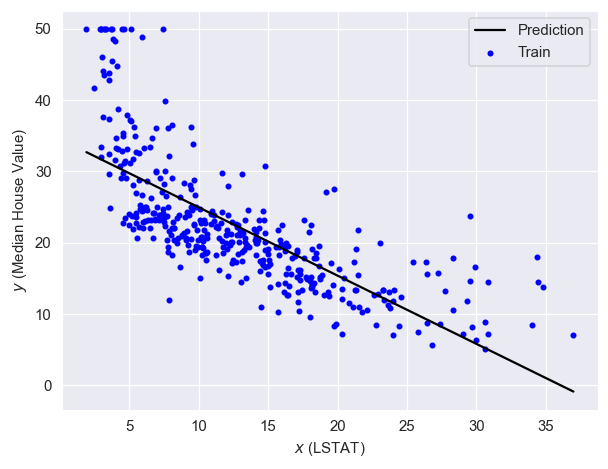

In [7]:
def predict(X, w):
    """Return the predicted response for a given design matrix and weights vector
    """
    return np.dot(X, w)

X_grid = np.linspace(X_train_s.min(), X_train_s.max(), num=1001)
x = np.column_stack((np.ones_like(X_grid), X_grid))
y = predict(x, w)
plt.plot(X_grid, y, 'k-', label='Prediction')
plt.scatter(X_train_s, y_train, color='b', marker='.', label='Train')
#plt.scatter(X_test_s, y_test, color='r', marker='.', label='Test')
plt.legend()
plt.ylabel("$y$ (Median House Value)")
plt.xlabel("$x$ (LSTAT)")
plt.show()

We'll compute the mean error term over the training and test sets to assess model performance.

In [8]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_pred - y_true) ** 2)

y_pred_train = predict(X_train_b, w)
y_pred_test = predict(X_test_b, w)
print('Train MSE:', mean_squared_error(y_pred_train, y_train))
print('Test MSE:', mean_squared_error(y_pred_test, y_test))

Train MSE: 38.632216441608094
Test MSE: 38.00420488101307


### 4. Linear regression using scikit-learn

Now that you have a good understanding of what's going on under the hood, you can use the functionality in scikit-learn to solve linear regression problems you encounter in the future. Using the `LinearRegression` module, fitting a linear regression model becomes a one-liner as shown below.

In [9]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train_s, y_train)

The `LinearRegression` module provides access to the bias weight $w_0$ under the `intercept_` property

In [10]:
lr.intercept_

34.515300040864204

and the non-bias weights under the `coef_` property

In [11]:
lr.coef_

array([-0.95801769])

You should check that these results match the solution you obtained previously. Note that sklearn also uses a numerical linear algebra solver under the hood.

Finally, what happens if we use the other 12 features available in the dataset? To make predictions, we can utilize the `predict` API. Scikit-learn also includes an implementation of the `mean_squared_error` function that we can import and employ to assess our implementation.

In [12]:
lr_full = LinearRegression().fit(X_train, y_train)
y_pred_train = lr_full.predict(X_train)
y_pred_test = lr_full.predict(X_test)

print('Train MSE:', mean_squared_error(y_pred_train, y_train))
print('Test MSE:', mean_squared_error(y_pred_test, y_test))

Train MSE: 20.05928429120229
Test MSE: 30.726949873388303


In [13]:
from sklearn.metrics import mean_squared_error as sk_mse
print('Train MSE:', sk_mse(y_pred_train, y_train))
print('Test MSE:', sk_mse(y_pred_test, y_test))

Train MSE: 20.05928429120229
Test MSE: 30.726949873388303


As measured by the MSE, our predictions are looking better. Although we obtained a performance boost here, in real problems you should be cautious of blindly including features in your analysis just because you can.

## 5. Basis expansion

Linear regression is simple and easy to interpret, however it cannot capture nonlinear relationships between the response and features. 
To deal with this problem, we can extend linear regression by mapping the features into another space where the relationship is (ideally) linear. 
This is known as _basis expansion_.
Specifically, we map the original feature vector $\mathbf{x} \in \mathbb{R}^m$ to a new feature vector $\varphi(\mathbf{x}) \in \mathbb{R}^k$. 
We then perform linear regression as before, replacing the original feature vectors with the new feature vectors: $y = w_0 + \sum_{i = 1}^{k} w_i \cdot \varphi_i(\mathbf{x})$. 
Note that this function is nonlinear in $\mathbf{x}$, but linear in $\mathbf{w}$. 

All of the previous results for simple linear regression carry over as you would expect by making the replacement $\mathbf{x} \to \varphi(\mathbf{x})$. 
For instance, the normal equation becomes: 

$$
\mathbf{w}^\star = \left[\mathbf{\Phi}^\top \mathbf{\Phi}\right]^{-1} \mathbf{\Phi}^\top \mathbf{y}
$$

where $\mathbf{\Phi} = \begin{pmatrix} \varphi(\mathbf{x}_1)^\top \\ \vdots \\ \varphi(\mathbf{x}_n)^\top \end{pmatrix}$ denotes the transformed design matrix.


There are many possible choices for the mapping $\varphi(\mathbf{x})$, but we'll focus on using polynomial basis functions in the single-feature case, e.g. $\varphi(x) = [1, x, x^2, \ldots, x^{k - 1}]^\top$ (note the first element corresponds to a bias term). 

We can compute the transformed design matrix using a built-in class from scikit-learn called `PolynomialFeatures`.
We'll start by considering polynomial features of degree 2.

In [14]:
from sklearn.preprocessing import PolynomialFeatures
degree = 2
poly = PolynomialFeatures(degree=degree)
Phi_train = poly.fit_transform(X_train_s)
Phi_test = poly.fit_transform(X_test_s)
print("Original design matrix (first 5 rows):\n", X_train_s[0:5], "\n")
print("Transformed design matrix (first 5 rows):\n", Phi_train[0:5])

Original design matrix (first 5 rows):
 [[12.8 ]
 [13.09]
 [27.38]
 [17.44]
 [ 1.92]] 

Transformed design matrix (first 5 rows):
 [[  1.      12.8    163.84  ]
 [  1.      13.09   171.3481]
 [  1.      27.38   749.6644]
 [  1.      17.44   304.1536]
 [  1.       1.92     3.6864]]


Now let's perform linear regression on the transformed training data and plot the resulting model. 

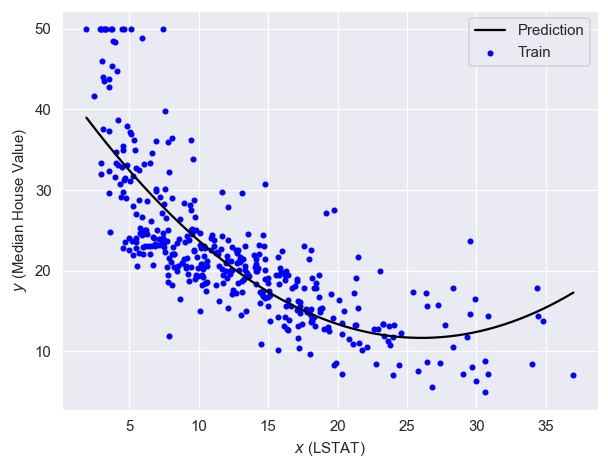

In [15]:
lr_poly = LinearRegression(fit_intercept=False).fit(Phi_train, y_train)

X_grid = np.linspace(X_train_s.min(), X_train_s.max(), num=1001)
Phi_grid = poly.fit_transform(X_grid[:,np.newaxis])
y = lr_poly.predict(Phi_grid)
plt.plot(X_grid, y, 'k-', label='Prediction')
plt.scatter(X_train_s, y_train, color='b', marker='.', label='Train')
#plt.scatter(X_test_s, y_test, color='r', marker='.', label='Test')
plt.legend()
plt.ylabel("$y$ (Median House Value)")
plt.xlabel("$x$ (LSTAT)")
plt.show()

Seems like a better fit than the linear model! Let's take a look at the error terms on the train/test set:

In [16]:
y_pred_train_poly = lr_poly.predict(Phi_train)
y_pred_test_poly = lr_poly.predict(Phi_test)
print('Train MSE for polynomial features of degree {}: {:.3f}'.format(degree, mean_squared_error(y_pred_train_poly, y_train)))
print('Test MSE for polynomial features of degree {}: {:.3f}'.format(degree, mean_squared_error(y_pred_test_poly, y_test)))

print('Train MSE using linear features only: {:.3f}'.format(mean_squared_error(lr.predict(X_train_s), y_train)))
print('Test MSE using linear features only: {:.3f}'.format(mean_squared_error(lr.predict(X_test_s), y_test)))

Train MSE for polynomial features of degree 2: 29.535
Test MSE for polynomial features of degree 2: 33.760
Train MSE using linear features only: 38.632
Test MSE using linear features only: 38.004


Strange, a large reduction on the train MSE but not so much on the test MSE. 
Lets scan across a range of powers. 
What do you expect to happen as we increase the maximum polynomial order on the training set? 
Take a minute to discuss with your fellow students before executing the next cell.

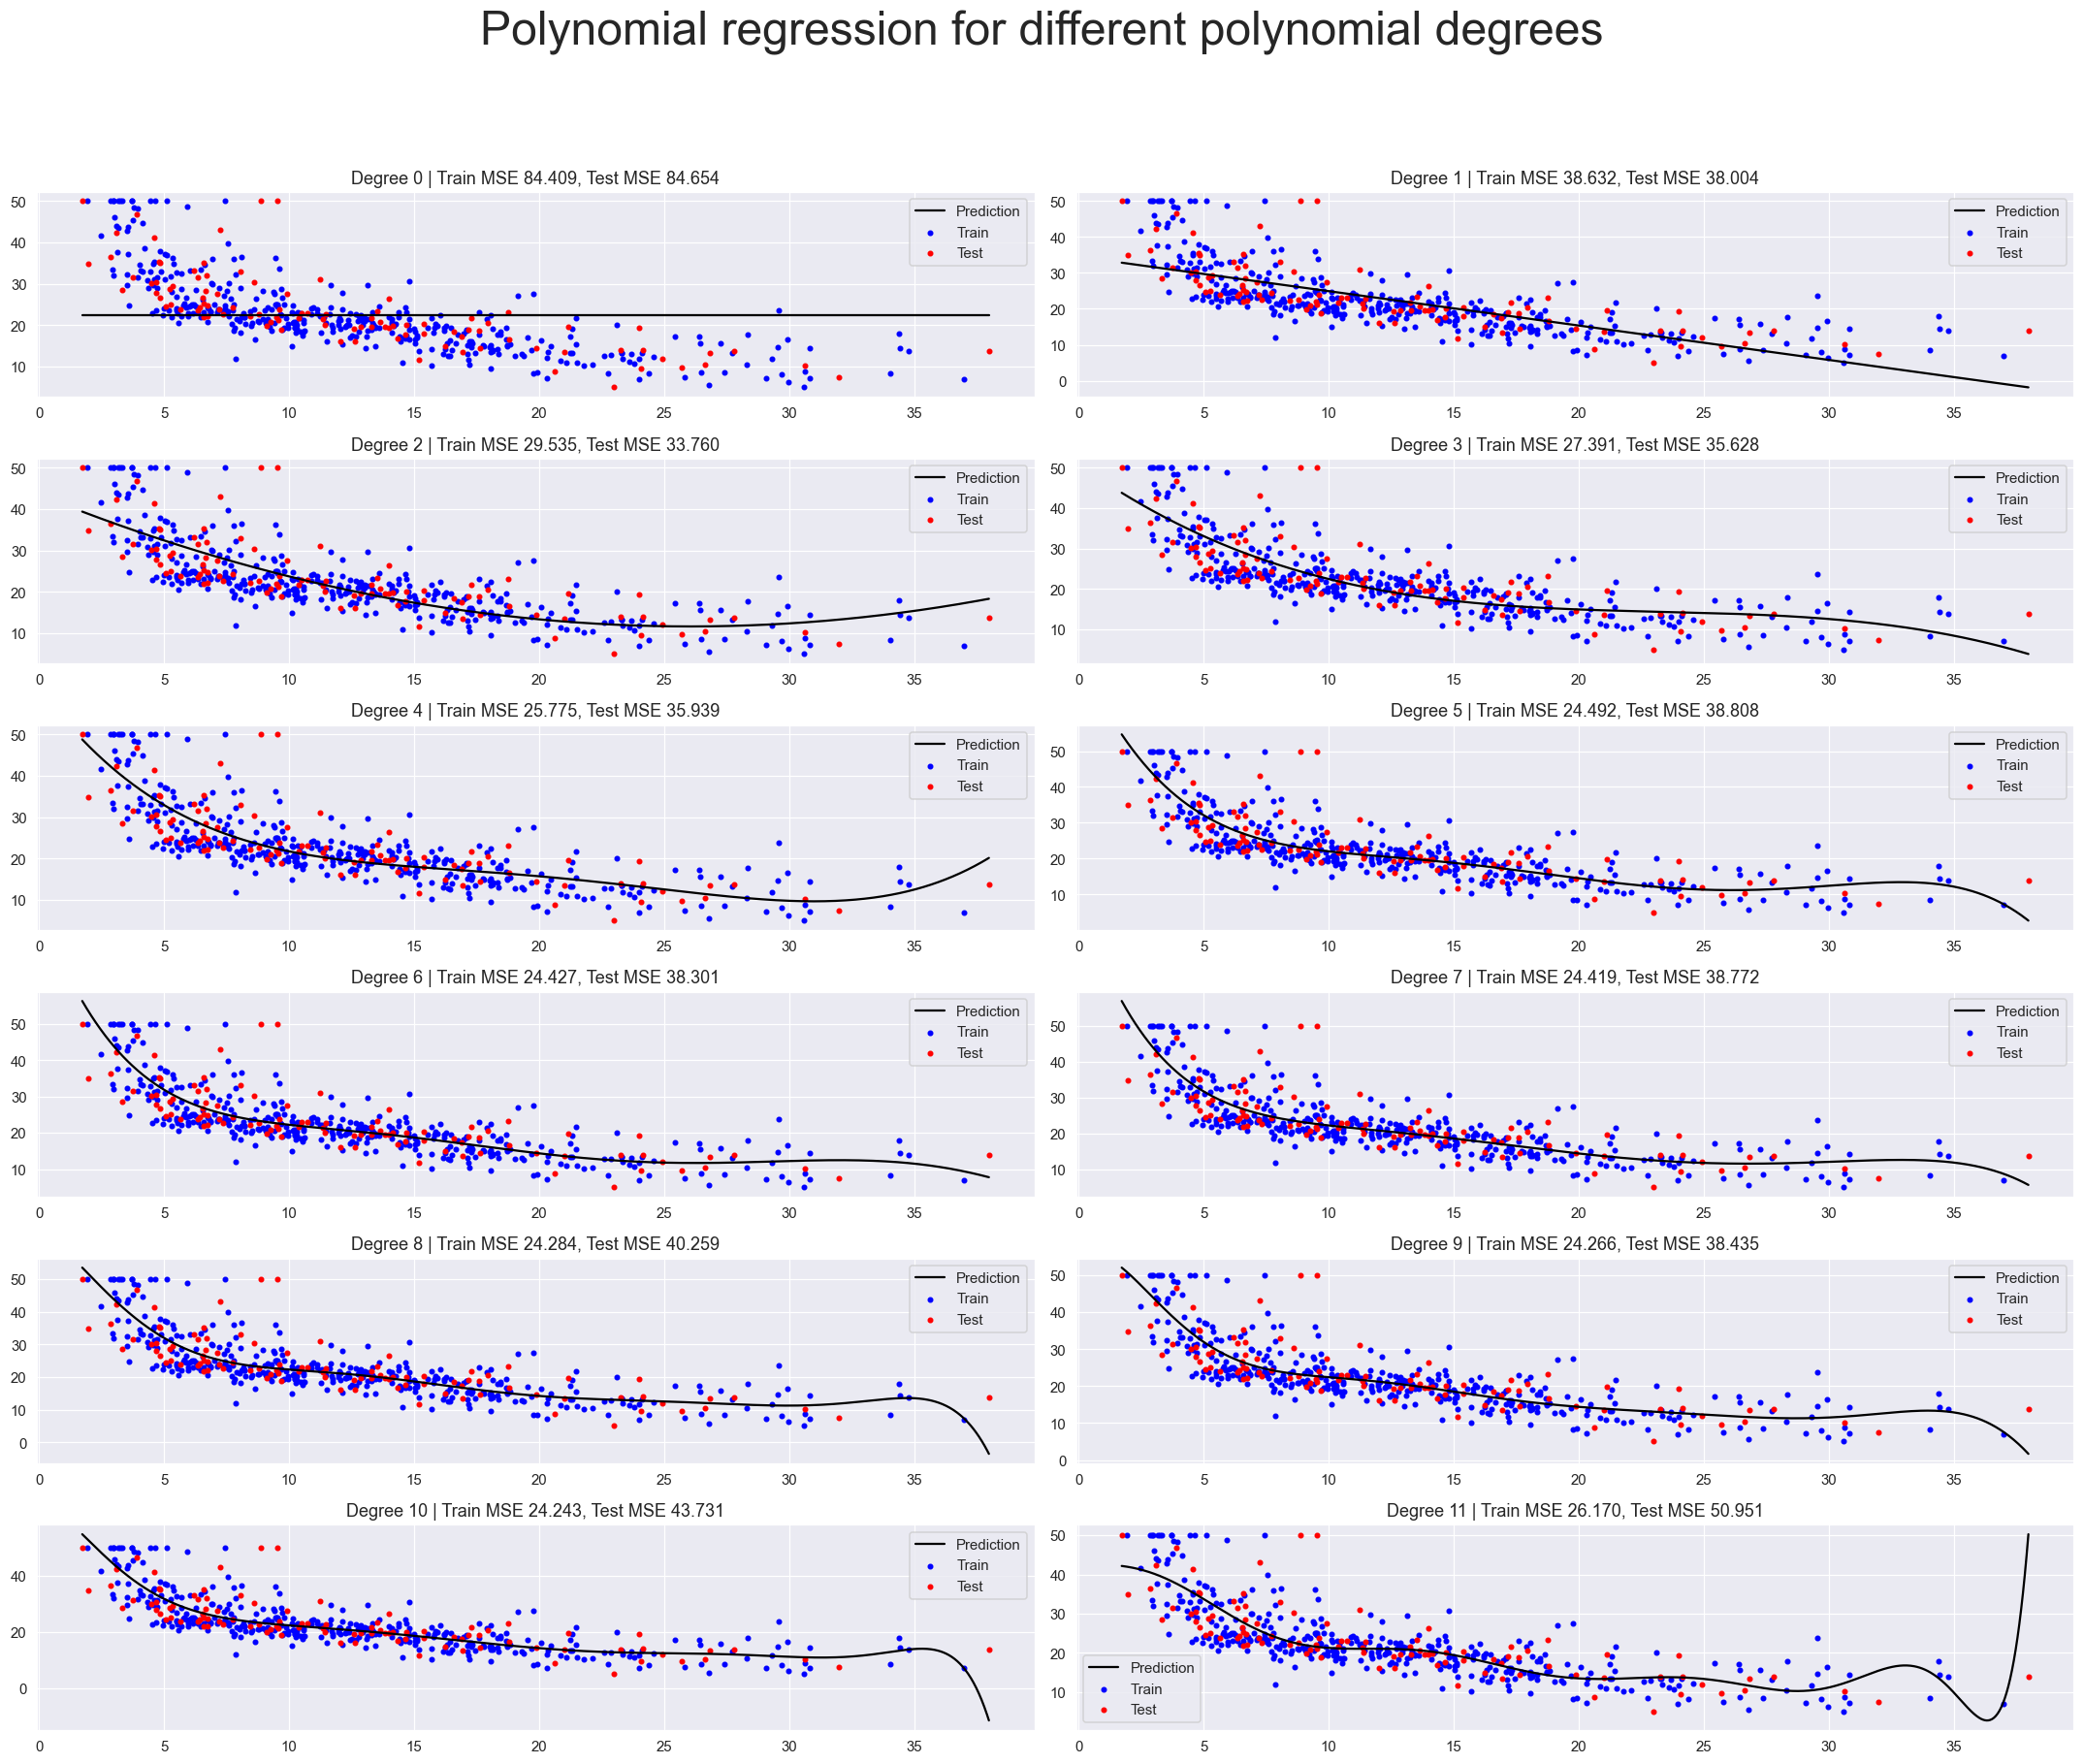

In [17]:
degrees = list(range(12))
models = list()
train_mses = list()
test_mses = list()

X_grid = np.linspace(min(X_train_s.min(), X_test_s.min()), 
                     max(X_train_s.max(), X_test_s.max()), num=1001)

plt.figure(figsize=(20,16))
for i, degree in enumerate(degrees):
    plt.subplot(len(degrees)//2, 2, i+1) 
    
    # Transform features
    poly = PolynomialFeatures(degree=degree)
    Phi_train, Phi_test = poly.fit_transform(X_train_s), poly.fit_transform(X_test_s)
    Phi_grid = poly.fit_transform(X_grid[:,np.newaxis])
    
    # Fit model
    lr_poly = LinearRegression().fit(Phi_train, y_train)
    models.append(lr_poly)
    
    # Evaluate
    train_mse = mean_squared_error(lr_poly.predict(Phi_train), y_train)
    train_mses.append(train_mse)
    test_mse = mean_squared_error(lr_poly.predict(Phi_test), y_test)
    test_mses.append(test_mse)
    
    plt.plot(X_grid, lr_poly.predict(Phi_grid), 'k', label='Prediction')
    plt.scatter(X_train_s, y_train, color='b', marker='.', label='Train')
    plt.scatter(X_test_s, y_test, color='r', marker='.', label='Test')
    plt.title('Degree {} | Train MSE {:.3f}, Test MSE {:.3f}'.format(degree, train_mse, test_mse))
    plt.legend()
    
plt.suptitle('Polynomial regression for different polynomial degrees', y=1.05, fontsize=32)
plt.tight_layout()

Let's plot mean-squared error vs. polynomial degree for the train and test sets.

In [ ]:
plt.plot(degrees, train_mses, color='b', label='Train')
plt.plot(degrees, test_mses, color='r', label='Test')
plt.title('MSE vs. polynomial degree')
plt.ylabel('MSE')
plt.xlabel('Polynomial degree')
plt.legend()
plt.show()

***
**Question**: 🤨 What's going on here? Does this match your earlier findings, or your intuition about which model was most appropriate? Why isn't test error behaving the same as training error?

***
## Bonus: Ridge regression (this section is optional)

One solution for managing the bias-variance trade-off is regularisation. 
In the context of regression, one can simply add a penalty term to the least-squares cost function in order to encourage weight vectors that are sparse and/or small in magnitude.
In this section, we'll experiment with ridge regression, where a $L_2$ (Tikhonov) penalty term is added to the cost function as follows:

$$
C(\mathbf{w}) = \| \mathbf{y} - \mathbf{X} \mathbf{w} \|_2^2 + \alpha \| \mathbf{w} \|_2^2
$$

***
**Exercise:** Repeat the previous section on polynomial regression with an $L_2$ penalty term and $\alpha = 0.002$. You may find the `sklearn.linear_model.Ridge` class useful.

_Note: You'll need to rescale the `LSTAT` feature (e.g. divide by 100) in order to avoid numerical issues._
***